# Detecting flower species from the images

**Context:**
A potential client approached us asking for a feasibility assessment of their big
idea. They want to build an app in which a user takes an image of the plants in
their garden and the app recognizes the plant, providing them information about
the plants health, care instructions and a possibility to share the image directly to
social media.

**Task:**
Your task is to train a quick proof of concept model verifying the feasibility of detecting
flower species in images coming from [**this dataset**](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html).

## Dataset
**Description:** 17-category flower dataset with 80 images for each class. The flowers chosen are some common flowers in the UK. The images have large scale, pose, and light variations and there are also classes with large variations of images within the class and close similarity to other classes.

## Solution
**Author:** Michał Dąbrowski, PhD \
**Time:** approx. 5-6 hours, including writting a report

### Import libraries

In [ ]:
# ! pip install requirements.txt

In [1]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Model and analysis parameters

I have decide to choose the [dataset prepared by Kaggle](https://www.kaggle.com/datasets/sanikamal/17-category-flower-dataset?resource=download) with samples separated by label in different catalogues, based on the original one which was lack of any description of how to label the images. This way I have an access to flower names as well which was not obvious from the original dataset. However, an alternative approach of data labeling is presented below as well. This another approach requires additional train-test splitting in the data processing pipeline.

```
# the flowers in the dataset are one-hot encoded in the order written in the classes list below
# classes = ['Daffodil','Snowdrop', 'Lily Valley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary',
             'Sunflower', 'Daisy', 'Colts Foot', 'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']

classes = [i for i in range(0,17)]
y = np.repeat(classes, 80)
y = tf.keras.utils.to_categorical(y, num_classes=17, dtype='float32')
```

In [2]:
# dataset folders
TRAIN_DATA_DIR = 'kaggle_dataset/train'
VALIDATION_DATA_DIR = 'kaggle_dataset/validation'

# model saving
MODEL_PATH = 'flower_recognition_model.h5'
HISTORY_PATH = 'model_history.json'

RANDOM_SEED = 42  # for choosing the images from the generator
BATCH_SIZE = 16  # for deep learning model training (crucial for GPU)
EPOCHS = 10  # limit the number of training epochs due to CPU processing

### Data augmentation and preprocessing
To properly prepared the inputs for the deep learning model, I use the following data generators. All the data need to be rescaled in intensity as well as in size to match the previously pre-trained neural network (as an example I use `VGG16` which accepts 224x224 pixel images). Moreover, 224x224 pixels strike a balance between capturing sufficient detail and maintaining computational feasibility. if the images are high-resolution but contain fine details that are not relevant to the classification task (e.g., background noise), resizing them to 224x224 pixels can help in focusing the model attention on the most relevant features. Additionally, because of the limited number of samples in the training dataset, I have decided to use data augmentation composed of rotation, shift, zoom and flip operations. Also, the data are prepared in batches which is convenient when used together with GPU. I will confirm the correct number of samples within each class.

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


In [25]:
# flower categories names
filepaths = validation_generator.filepaths  

class_labels = list(validation_generator.class_indices.keys())
class_labels

['bluebell',
 'buttercup',
 'colts_foot',
 'cowslip',
 'crocus',
 'daffodil',
 'daisy',
 'dandelion',
 'fritillary',
 'iris',
 'lily_valley',
 'pansy',
 'snowdrop',
 'sunflower',
 'tigerlily',
 'tulip',
 'windflower']

### Plot class samples fram the training dataset

Here I plot original sample images from each category within training dataset. It is worth noticing the images have different shapes, quality, as well as withing some categories the samples look completely different among each other. Also, there is a lot of yellow flowers which can bias the model somehow.

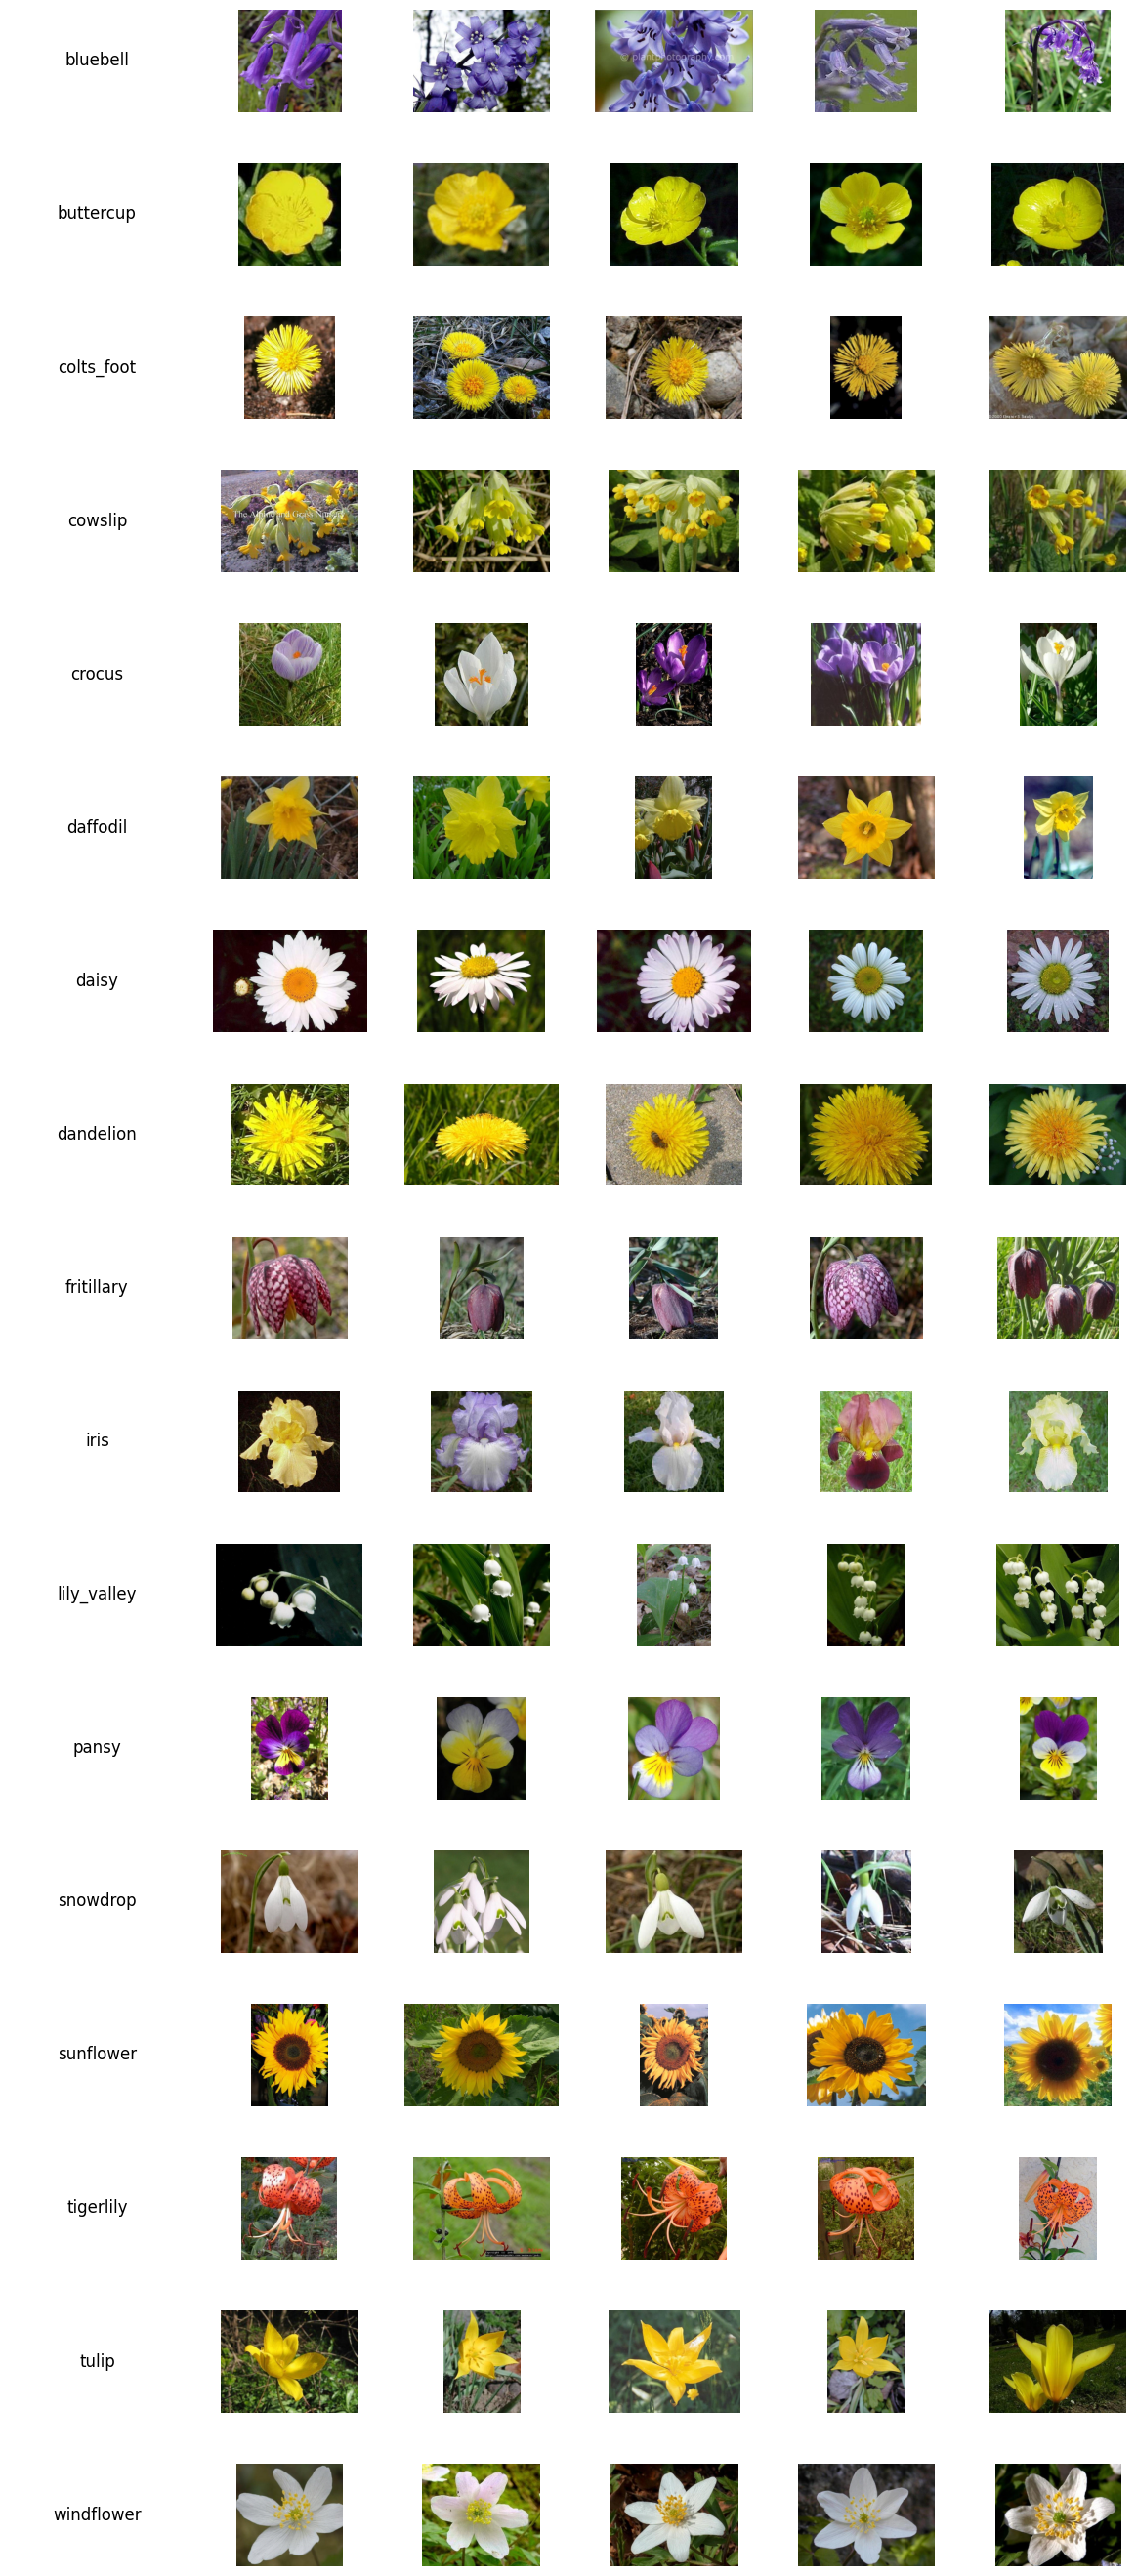

In [4]:
def plot_class_samples(generator, class_labels, num_samples=5):
    """function to plot original images from the dataset, for each category"""
    fig, axes = plt.subplots(len(class_labels), num_samples + 1, figsize=(15, 2 * len(class_labels)))

    for ax in axes.flatten():
        ax.axis('off')

    for i, class_name in enumerate(class_labels):
        class_dir = os.path.join(generator.directory, class_name)
        sample_images = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)[:num_samples]]
        
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
        axes[i, 0].axis('off')

        for j, img_path in enumerate(sample_images):
            img = plt.imread(img_path)
            axes[i, j + 1].imshow(img)
            axes[i, j + 1].axis('off')

            # Ensure to break if already plotted the required number of images
            if j + 1 >= num_samples:
                break

    plt.subplots_adjust(hspace=0.5, wspace=0.1)
    plt.show()

class_labels = list(train_generator.class_indices.keys())
plot_class_samples(train_generator, class_labels)

### Plot some training images after augmentation
Here I have plotted 10 examples of images after data augmentation, all coming from the training dataset, but previously scaled in size to match the further explained `VGG16` deep learning model, as well as normalized in intensity. The original images are being shifted, rotated, and flipped horizontaly.

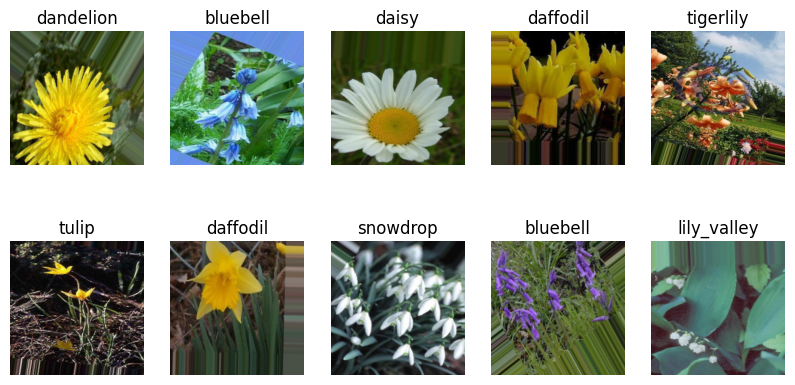

In [5]:
def plot_augmented_images(generator, class_names, n=10):
    """function to plot augmented images, for chosen number of samples"""
    augmented_images, augmented_labels = next(generator)

    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.subplot(2, 5, i + 1)
        plt.imshow(augmented_images[i])
        plt.title(class_names[np.argmax(augmented_labels[i])])
        plt.axis('off')
    plt.show()

class_names = list(train_generator.class_indices.keys())
plot_augmented_images(train_generator, class_names, n=10)

### Upload transfer learning model
Because of the limited dataset size, I have decided to use a transfer learning model. Because the sampes are images, as a base model I use `VGG16`, but any other convolutional neural network can be used, including different models from `VGG` family, as well as `ResNet50` or `MobileNet` models, amont others. These models are pre-trained on `ImageNet` dataset and can be fine-tuned for flower classification. I have added additional dense hidden layer and softmax layer as an output, then the model is compiled with `Adam` optimizer and `categorical_crossentropy` as a loss function. I decided to choose an `accuracy` as a metric to optimmize the model for. Because of the limited time and data resources I decided to drop the stage of choosing the optimal hyperparameters of the model (via `GridSearch` or `RandomSearch`) which will require additional splitting of the training dataset e.g., via crossvalidation.

In [6]:
def create_model():
    """create a transer learning model, with 'VGG16' as a base model"""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(17, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,141,841 (80.65 MB)

 Trainable params: 6,427,153 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Model and history loading if available
Because the training can take long time using CPU, I decided to save the model parameters together with the history of model performance, for further training if needed. This way we avaoid training a new model from scratch every time, and gain the possibility to train the same model on a new dataset if available. If the previosuly trained model and history are not present, the model is trained from the beginning, taking the previously defined architecture.

In [11]:
# Check if the model file exists and load it or create a new one
if os.path.exists(MODEL_PATH):
    model = load_model(MODEL_PATH)
    print(f'Model loaded from [{MODEL_PATH}]')
else:
    model = create_model()
    print('New model created.')

# Check if the history file exists and load it
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, 'r') as f:
        history_dict = json.load(f)
    print(f'History loaded from [{HISTORY_PATH}]')
else:
    print(f'History file [{HISTORY_PATH}] does not exist.')

Model loaded from [flower_recognition_model.h5]
History loaded from [model_history.json]


### Train the model
Here is the model training. I decide to use `EarlyStopping` procedure to avoid overfiting and stop the training at the point where the model performance on the validation set starts descreasing. After each epoch the model `accuracy` is measured on both datasets as well as loss function values are registered. Finally, the model is saved to the sepatate file to be used later on, as described above.

In [9]:
# Train the model if it was newly created or continue training
if history_dict is None:
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the model
    model.save(MODEL_PATH)
    print(f'Model saved to [{MODEL_PATH}]')

    # Save the history
    history_dict = history.history
    with open(HISTORY_PATH, 'w') as f:
        json.dump(history_dict, f)
    print(f'History saved to [{HISTORY_PATH}]')
else:
    print('Skipping training as model and history are loaded.')

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - accuracy: 0.3568 - loss: 2.1748 - val_accuracy: 0.6412 - val_loss: 1.1285
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.6234 - loss: 1.2740 - val_accuracy: 0.7588 - val_loss: 0.8436
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 278s 4s/step - accuracy: 0.7459 - loss: 0.9021 - val_accuracy: 0.8294 - val_loss: 0.6107
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.7953 - loss: 0.7594 - val_accuracy: 0.7824 - val_loss: 0.6660
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - accuracy: 0.7970 - loss: 0.6967 - val_accuracy: 0.8059 - val_loss: 0.6086
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.8304 - loss: 0.6137 - val_accuracy: 0.8647 - val_loss: 0.4473
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.8639 - loss: 0.5099 - val_accuracy: 0.8588 - val_loss: 0.4661
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8953 - loss: 0.4125 - val_accuracy: 0.8941 - v

Model saved to flower_recognition_model.h5
History saved to model_history.json


### Evaluate the model on the validation set
Below is the summary of the model performance which is quite well, at the level of 85-90% in accuracy. The model is not overfitted as the values are similar to the training dataset in the final epoch. The good training bahariour is also confirmed on the model accuracy and model loss plots below. It is clearly see there is no overfitting but the model is a little underfitted as the loss values for both training and validation sets do not drop down to zero during training. The reason can be the following: the structure of the image is too complex for a particular deel learing model - possible reason is the presence of a complicated background on some images which might distract the algorithm. Also, the far-from-zero loss can be caused by one particular class label where the images divergence is large and the resolution (quality) not pretty well. 

In [12]:
# metrics calculated on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8502 - loss: 0.5391
Validation Loss: 0.4085, Validation Accuracy: 89.41%


### Plot accuracy and loss values

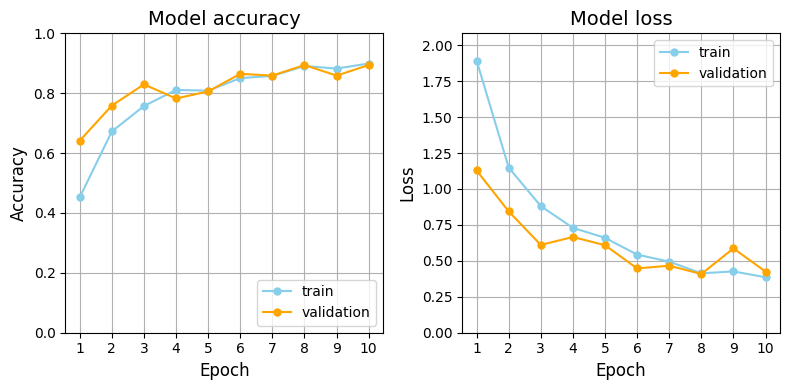

In [17]:
def plot_learning_curves(history):
    """plot the model accuracy and loss during training"""
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], marker='o', markersize=5, color='skyblue', label='train')
    plt.plot(history['val_accuracy'], marker='o', markersize=5, color='orange', label='validation')
    plt.title('Model accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(ticks=np.arange(EPOCHS), labels=np.arange(1, EPOCHS+1)) 
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], marker='o', markersize=5, color='skyblue', label='train')
    plt.plot(history['val_loss'], marker='o', markersize=5, color='orange', label='validation')
    plt.title('Model loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(ticks=np.arange(EPOCHS), labels=np.arange(1, EPOCHS+1)) 
    plt.ylim(0, 1.1*max(history['loss']))
    plt.grid(True)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_dict)

### Get the true labels and predictions

In [18]:
# predict actual class and class probabilities
validation_generator.reset()
y_prob = model.predict(validation_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = validation_generator.classes

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


### Generate classification report and confusion matrix
The model achieved a validation accuracy of approx. 90%. The consussion matrix indicates that most misclassifications occured between visually similar speciel. The model had high precission and recall for most classes, with an average F1-score of around 0.89. In particular, `cowslip` category is very poorly classified which is confirmed by a very-low recall value. On average, the model does not work with `lily_valey` class as well.


              precision    recall  f1-score   support

    bluebell       0.88      0.70      0.78        10
   buttercup       0.91      1.00      0.95        10
  colts_foot       1.00      1.00      1.00        10
     cowslip       1.00      0.10      0.18        10
      crocus       0.91      1.00      0.95        10
    daffodil       0.83      1.00      0.91        10
       daisy       1.00      1.00      1.00        10
   dandelion       1.00      1.00      1.00        10
  fritillary       1.00      1.00      1.00        10
        iris       0.71      1.00      0.83        10
 lily_valley       0.83      0.50      0.62        10
       pansy       0.91      1.00      0.95        10
    snowdrop       0.90      0.90      0.90        10
   sunflower       1.00      1.00      1.00        10
   tigerlily       1.00      1.00      1.00        10
       tulip       0.91      1.00      0.95        10
  windflower       0.67      1.00      0.80        10

    accuracy              

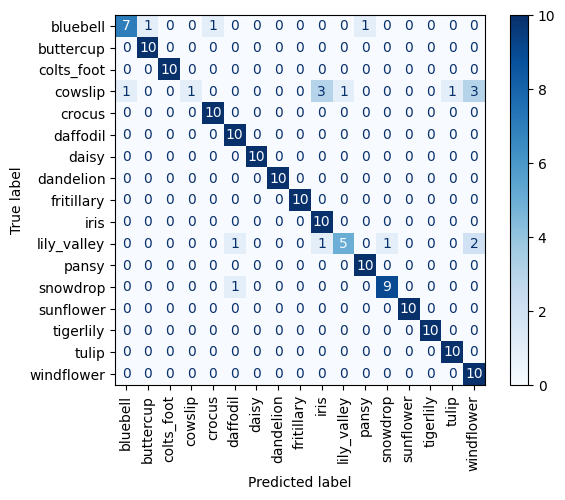

In [19]:
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

### Plot the predicted results on the validation dataset
Below are the samples of correctly and wrongly classified samples, picked randomly from a validation dataset. You can change the code to plot the training dataset examples by modyfing the following variable: `filepaths = validation_generator.filepaths`. Also, instead of picking samples at random (but with the predefined `RANDOM_SEED`), one can choose a list of index of samples to be plotted. Additionally, below is an example of `cowslip` category with accuracy much lower than average on the whole dataset.

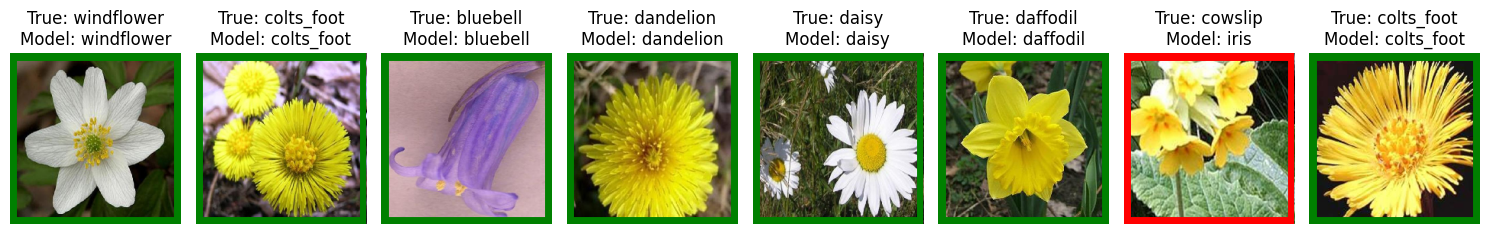

In [28]:
def plot_class_samples(filepaths, y_true, y_pred, class_labels, indices):
    """mark correct and wrong classified examples by green and red frames"""
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))

    for i, idx in enumerate(indices):
        img_path = filepaths[idx]
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0  # Normalize the image

        true_label = class_labels[y_true[idx]]
        pred_label = class_labels[y_pred[idx]]

        axes[i].imshow(img_array)
        axes[i].set_title(f'True: {true_label}\nModel: {pred_label}')
        axes[i].axis('off')
        
        if y_true[idx] == y_pred[idx]:
            rect_color = 'green'
        else:
            rect_color = 'red'
            
        rect = plt.Rectangle((0, 0), 224, 224, linewidth=10, edgecolor=rect_color, facecolor='none')
        axes[i].add_patch(rect)

    plt.tight_layout()
    plt.show()

random.seed(RANDOM_SEED)
indices = random.sample(range(len(filepaths)), 8)
# indices = [1, 12, 45, 67, 101]
plot_class_samples(filepaths, y_true, y_pred, class_labels, indices)

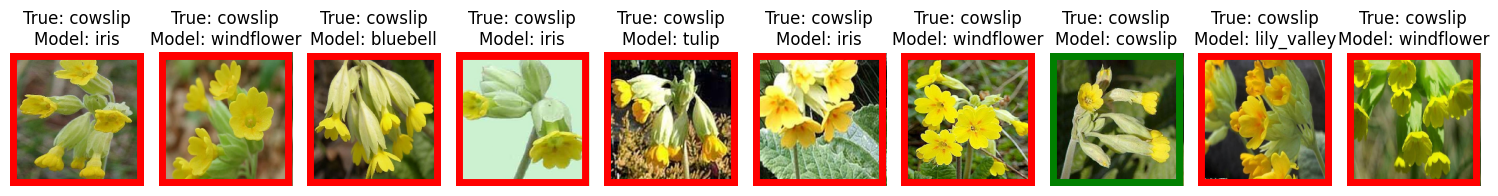

In [29]:
# example of wrong predictions on a 'cowslip' class
indices = [i for i in range(30, 40)]
plot_class_samples(filepaths, y_true, y_pred, class_labels, indices)

### Plot the probabilities on the validation dataset
Additionally, I have decided to plot the top-3 classes predicted for each chosen sample. As above, one can choose between random list of samples or pick them from a given list. It is worth noticing same samples belong in almost 100% to just one class while some others belongs to more than one class. In particular, sometimes top probability (or even both top-2 probabilities) is below 50% thus the samples misclassification. The solution to overcome this issue will be to choosenanother threshold for sample classification (at the cost of lowering the recall). Another possibility is to change the metric used for model optimization, as well as adding additional `other` class where samples with low top-3 probabilities will belong to. 

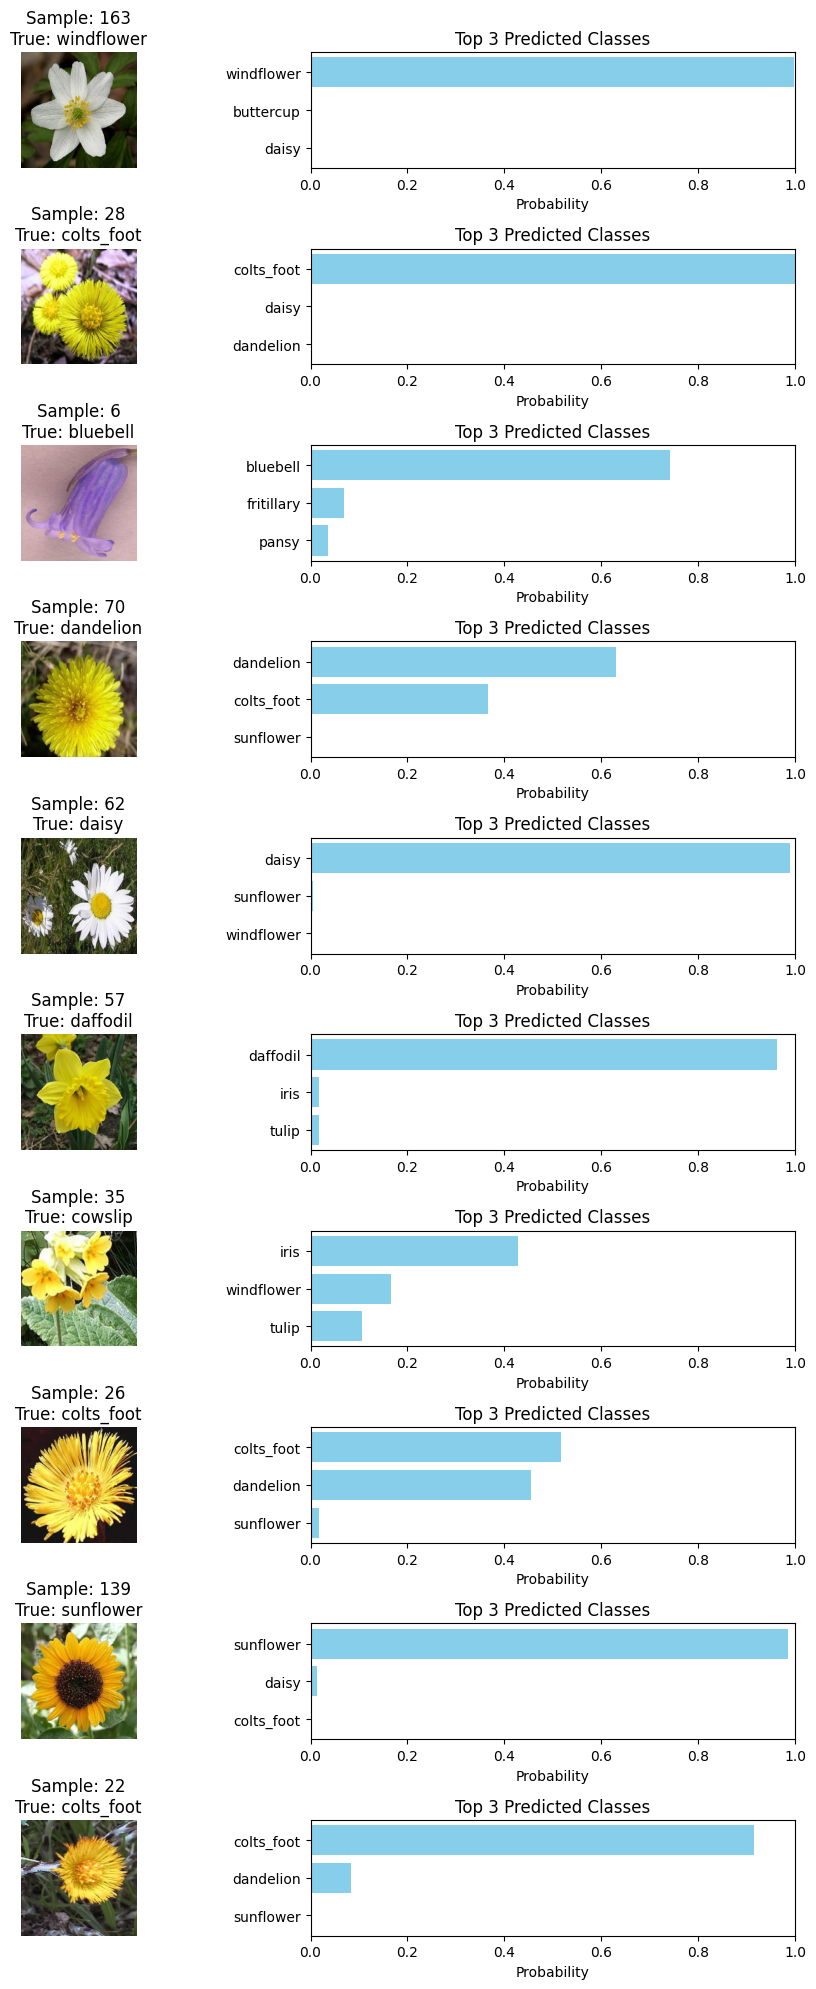

In [39]:
def plot_images_with_predictions(filepaths, y_true, y_prob, class_labels, indices):
    """show the top-3 most probably classes for each classified sample, with probabilities"""
    plt.figure(figsize=(10, 2*len(indices)))

    for i, idx in enumerate(indices):

        img_path = filepaths[idx]
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
        
        true_label = class_labels[y_true[idx]]
        top_classes = np.argsort(y_prob[idx])[::-1][:3]
        top_probs = y_prob[idx, top_classes]

        plt.subplot(len(indices), 2, 2*i+1)
        plt.imshow(img)
        plt.title(f'Sample: {idx}\nTrue: {true_label}')
        plt.axis('off')

        plt.subplot(len(indices), 2, 2*i+2)
        class_labels_top3 = [class_labels[class_idx] for class_idx in top_classes]
        plt.barh(class_labels_top3, top_probs, color='skyblue')
        plt.xlabel('Probability')
        plt.title('Top 3 Predicted Classes')
        plt.xlim(0, 1)
        plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

random.seed(RANDOM_SEED)
indices = random.sample(range(len(filepaths)), 10)
plot_images_with_predictions(filepaths, y_true, y_prob, class_labels, indices)

### Summary
The goal of this project was to develop a plant recognition app using deep learning techniques. The model is trained to classify images of plants into different species and provide information about their health and care instructions based on the image. The dataset used for this project is the `17 Category Flower Dataset` from Kaggle, comprising 17 different classes of flower species. The dataset is split into training and validation sets. Each class directory contains images of different flower species, with varying numbers of images per class. Preprocessing involved resizing all images to 224x224 pixels and applying normalization to bring pixel values within a standardized range. `VGG16` model was chosen for its balance between performance and computational efficiency. The model was compiled with the categorical cross-entropy loss function and the Adam optimizer. A batch size of 16 and training for 10 epochs were chosen based on initial experimentation and computational feasibility. Training progress was monitored using training and validation accuracy and loss metrics. Early stopping was implemented based on validation loss to prevent overfitting and improve generalization. The model achieved an accuracy of approximately 90% on the validation set after 10 epochs. Training and validation accuracy and loss curves were plotted to visualize model convergence and identify potential overfitting. A confusion matrix was generated to analyze the model's performance across different flower species, highlighting any specific challenges or biases.